In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from scipy.stats import iqr

import os

In [2]:
from lib.success_rate_N_estimation import get_N_success_rate, get_rho
from lib.exponential_fitting import fit_exponential_n, show_elbow_n
from lib.tools import filter_n, filter_r
from lib.projected_kernel import densities_2_kernel

# Import data

In [3]:
m=208

## Kernel entries

In [5]:
path_2_k = 'results/sonar/projected_entries/full'

files_k = []
for file in os.listdir(path_2_k):
    if file.endswith('.csv'):
        files_k.append(os.path.join(path_2_k, file))
files_k.sort()

In [6]:
k_ZZ = []
for f in files_k:
    k_ZZ.append(pd.read_csv(f, header=None).to_numpy())
k_ZZ = np.array(k_ZZ)

In [7]:
n_range = np.arange(2,k_ZZ[0].shape[0]+2, 1)

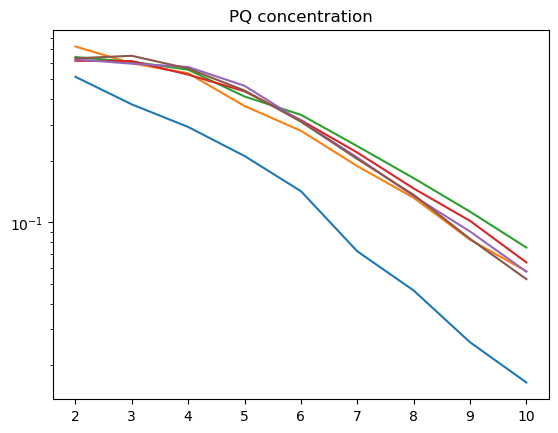

In [8]:
plt.plot(n_range,1-np.median(k_ZZ,axis=2).T)
plt.yscale('log')
plt.title('PQ concentration')
plt.show()

## RMDS

In [9]:
path_2_rdms = 'results/sonar/reduced_density_matrices/full/'

files_rmds = []
for file in os.listdir(path_2_rdms):
    if file.endswith('.npy'):
        files_rmds.append(os.path.join(path_2_rdms, file))
files_rmds.sort()

In [10]:
ZZ_values = np.array([int(f[-5:-4]) for f in files_rmds])
ZZ_values = np.sort(np.unique(ZZ_values))

#n_values = []
#for ZZ in ZZ_values:
#    files_ZZ_n = filter_r(r=ZZ, files=files_rmds)
#    n_vals_ZZ = np.array([int(f[-11:-9]) for f in files_ZZ_n])
#    n_vals_ZZ = np.sort(np.unique(n_vals_ZZ))
#    n_values.append(n_vals_ZZ)

n_values = np.arange(2,10+0.1,1, dtype=int)

# Success rate

In [11]:
P_SR = 0.99
mu = 0.5

In [12]:
NSRs_ZZ = []
for k in k_ZZ:
    epsilon_limits = get_rho(k, n_range=n_range)
    Ns = [get_N_success_rate(P_SR, mu, mu-epsilon_limit) for epsilon_limit in epsilon_limits]
    NSRs_ZZ.append(Ns)

NSRs_ZZ = np.array(NSRs_ZZ)


In [13]:
best_qubits = [7,5,7,5,4,3]
fits_N_SR = np.empty((NSRs_ZZ.shape[0],2))

for i in range(NSRs_ZZ.shape[0]):
    #show_elbow_n(Ns_ZZ[i], best_qubit=best_qubits[i])
    fits_N_SR[i,0], fits_N_SR[i,1] = fit_exponential_n(NSRs_ZZ[i], best_qubit=best_qubits[i], show_plot=False)

print(fits_N_SR)

[[ 0.89235576 10.5453559 ]
 [ 0.78583903  6.43673182]
 [ 0.73065027  6.85085018]
 [ 0.79819189  5.11267349]
 [ 0.83818896  4.45932532]
 [ 0.86160653  4.08430422]]


In [14]:
n_extrapolation_max = 100
n_extrapolation = np.arange(n_range[-1], n_extrapolation_max+0.1,1)

NSRs_extrapolation = np.array([fits_N_SR[i,1]*np.power(2, fits_N_SR[i,0]*n_extrapolation) for i in range(NSRs_ZZ.shape[0])])

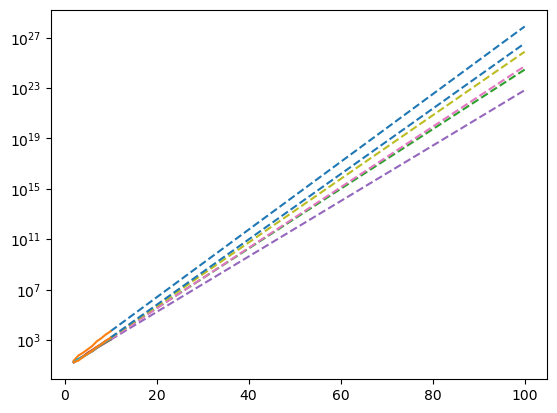

In [15]:
for i in range(NSRs_extrapolation.shape[0]):
    plt.plot(n_extrapolation, NSRs_extrapolation[i], linestyle='dashed')
    plt.plot(n_range, NSRs_ZZ[i])
plt.yscale('log')
plt.show()

# Measurement resolution

In [16]:
def N_MR(k_ie, epsilon=1, gamma=1):
    delta_ensemble = iqr(k_ie)
    N_MR = np.sqrt(-1.0*(2*gamma)/(np.log(1-epsilon*delta_ensemble)))
    return(N_MR)

In [17]:
N_MRs_ZZ = []
for i in range(k_ZZ.shape[0]):
    N_MRs = [N_MR(k) for k in k_ZZ[i]]
    N_MRs_ZZ.append(N_MRs)

N_MRs_ZZ = np.array(N_MRs_ZZ)

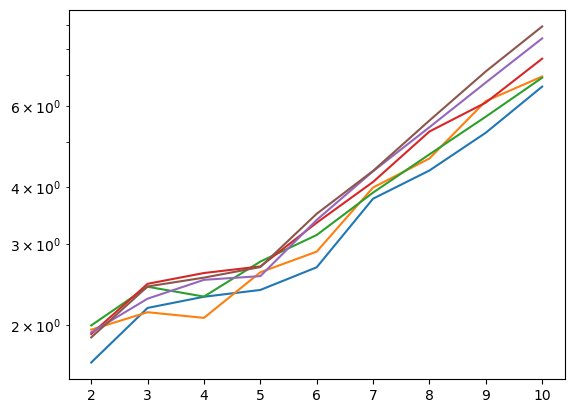

In [18]:
for i in range(N_MRs_ZZ.shape[0]):
    plt.plot(n_range, N_MRs_ZZ[i])
plt.yscale('log')
plt.show()

Absolutely no sense in cosidering this effect!

# Spread

In [19]:
from lib.tools import filter_n, filter_r
from lib.spread_N_estimation import V_k, V_k_noisy, N_spread

In [20]:
P_spread = 0.99

## V

In [21]:
V_medians_ZZ = []
V_medians_ZZ_noisy = []
for ZZ_id, ZZ in enumerate(ZZ_values):
    print('ZZ: ', ZZ)
    median_Vs_p_n = []
    median_Vs_p_n_noisy = []
    for n_qubits in n_range:
        file = filter_r(r=ZZ, files=files_rmds)
        file = filter_n(n=n_qubits, files=file)[0]

        RM = np.load(file)

        Vs = np.empty((m*(m-1)//2,n_qubits))
        Vs_noisy = np.empty((m*(m-1)//2,n_qubits))
        for k in range(n_qubits):
            index = 0
            for i in range(m):
                for j in range(i):
                    x_dens = RM[i]
                    y_dens = RM[j]
                    Vs[index, k] = V_k(k=k, x_densities=x_dens, y_densities=y_dens)
                    Vs_noisy[index, k] = V_k_noisy(k=k, x_densities=x_dens, y_densities=y_dens)
                    index += 1
        V=Vs.sum(axis=1)
        V_noisy=Vs_noisy.sum(axis=1)
        median_Vs_p_n.append(np.median(V)/n_qubits)
        median_Vs_p_n_noisy.append(np.median(V_noisy)/n_qubits)

    median_Vs_p_n = np.array(median_Vs_p_n)
    median_Vs_p_n_noisy = np.array(median_Vs_p_n_noisy)

    V_medians_ZZ.append(median_Vs_p_n)
    V_medians_ZZ_noisy.append(median_Vs_p_n_noisy)
V_medians_ZZ = np.array(V_medians_ZZ)
V_medians_ZZ_noisy = np.array(V_medians_ZZ_noisy)

ZZ:  1


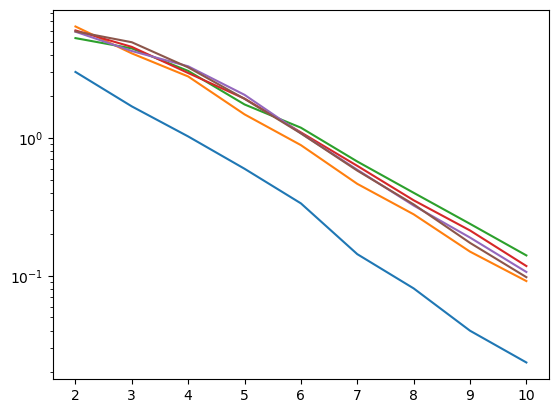

In [24]:
for medians in V_medians_ZZ:
    plt.plot(n_values,medians)
plt.yscale('log')
plt.show()

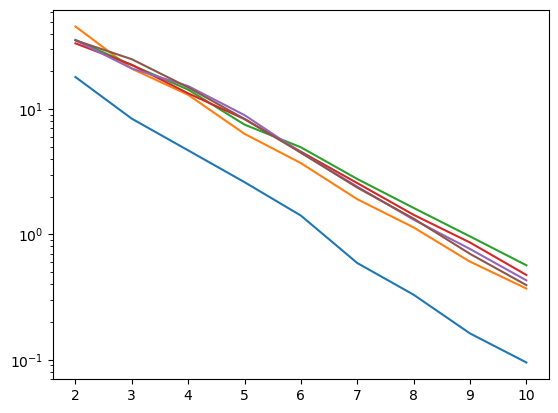

In [25]:
for medians in V_medians_ZZ_noisy:
    plt.plot(n_values,medians)
plt.yscale('log')
plt.show()

In [26]:
best_qubits = [4, 4, 7, 5, 4, 5]
fits_V_p_N = np.empty((V_medians_ZZ.shape[0],2))
fits_V_p_N_noisy = np.empty((V_medians_ZZ_noisy.shape[0],2))

for i in range(V_medians_ZZ.shape[0]):
    #show_elbow_n(Ns_ZZ[i], best_qubit=best_qubits[i])
    fits_V_p_N[i,0], fits_V_p_N[i,1] = fit_exponential_n(V_medians_ZZ[i], best_qubit=best_qubits[i], show_plot=False)
    fits_V_p_N_noisy[i,0], fits_V_p_N_noisy[i,1] = fit_exponential_n(V_medians_ZZ_noisy[i], best_qubit=best_qubits[i], show_plot=False)

print(fits_V_p_N)
print(fits_V_p_N_noisy)

[[-0.93480603 14.57932145]
 [-0.82343854 26.51712633]
 [-0.75310341 26.10329224]
 [-0.80202557 30.88189784]
 [-0.83822288 35.10786654]
 [-0.86260936 38.53555572]]
[[ -0.96441092  70.45322421]
 [ -0.85364323 128.44197305]
 [ -0.76232072 111.6380183 ]
 [ -0.82123829 140.14719777]
 [ -0.8692237  170.50499802]
 [ -0.88294505 175.84063341]]


In [27]:
n_extrapolation_max = 100
n_extrapolation = np.arange(n_range[-1], n_extrapolation_max+0.1,1)

V_extrapolation = np.array([fits_V_p_N[i,1]*np.power(2, fits_V_p_N[i,0]*n_extrapolation) for i in range(V_medians_ZZ.shape[0])])
V_extrapolation_noisy = np.array([fits_V_p_N_noisy[i,1]*np.power(2, fits_V_p_N_noisy[i,0]*n_extrapolation) for i in range(V_medians_ZZ_noisy.shape[0])])

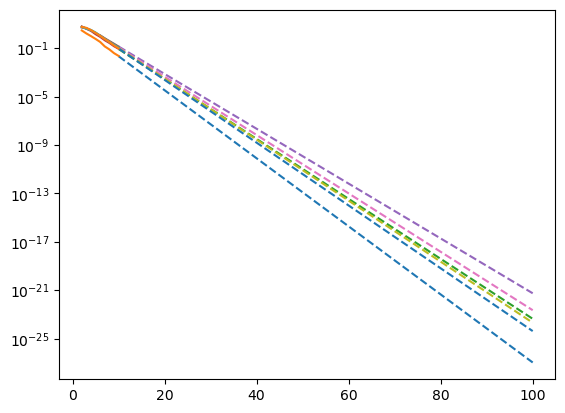

In [28]:
for i in range(V_extrapolation.shape[0]):
    plt.plot(n_extrapolation, V_extrapolation[i], linestyle='dashed')
    plt.plot(n_range, V_medians_ZZ[i])
plt.yscale('log')
plt.show()

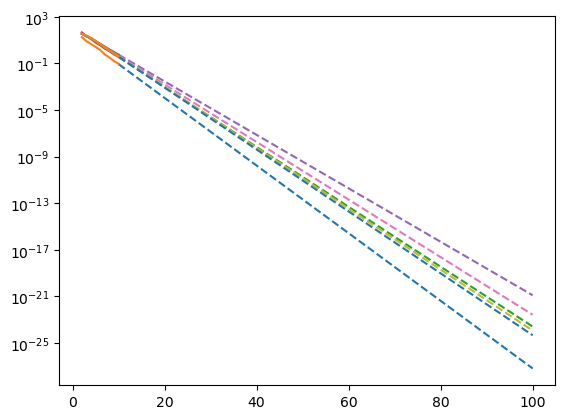

In [29]:
for i in range(V_extrapolation_noisy.shape[0]):
    plt.plot(n_extrapolation, V_extrapolation_noisy[i], linestyle='dashed')
    plt.plot(n_range, V_medians_ZZ_noisy[i])
plt.yscale('log')
plt.show()

## Delta_ensemble

In [30]:
k_IQRS = iqr(k_ZZ, axis=2)

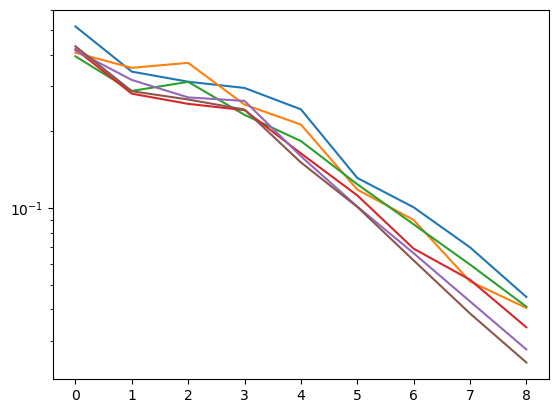

In [31]:
plt.plot(k_IQRS.T)
plt.yscale('log')

In [32]:
best_qubits = [5,4,4,5,5,5]
fits_Delta_ensemble = np.empty((k_IQRS.shape[0],2))

for i in range(k_IQRS.shape[0]):
    #show_elbow_n(Ns_ZZ[i], best_qubit=best_qubits[i])
    fits_Delta_ensemble[i,0], fits_Delta_ensemble[i,1] = fit_exponential_n(k_IQRS[i], best_qubit=best_qubits[i], show_plot=False)

print(fits_Delta_ensemble)

[[-0.55487701  2.14712329]
 [-0.55180396  1.80017837]
 [-0.4925681   1.3046412 ]
 [-0.5659819   1.71437665]
 [-0.64303784  2.36180226]
 [-0.66026879  2.40441912]]


In [33]:
n_extrapolation_max = 100
n_extrapolation = np.arange(n_range[-1], n_extrapolation_max+0.1,1)

Delta_extrapolation = np.array([fits_Delta_ensemble[i,1]*np.power(2, fits_Delta_ensemble[i,0]*n_extrapolation) for i in range(k_IQRS.shape[0])])

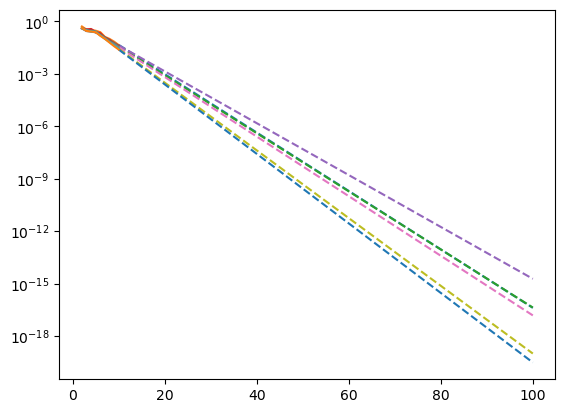

In [34]:
for i in range(Delta_extrapolation.shape[0]):
    plt.plot(n_extrapolation, Delta_extrapolation[i], linestyle='dashed')
    plt.plot(n_range, k_IQRS[i])
plt.yscale('log')
plt.show()

## Kappa

In [35]:
M_kappa = np.median(k_ZZ, axis=2)
M_conc_kappa = 1-M_kappa

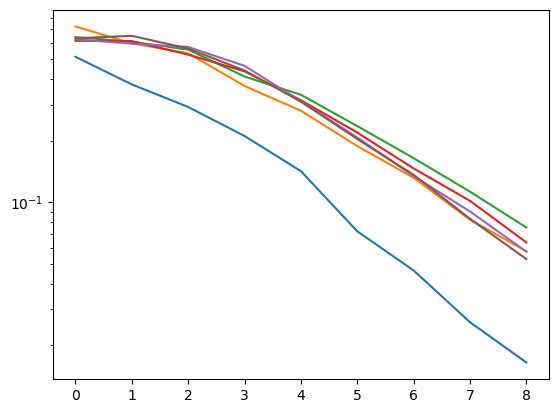

In [36]:
plt.plot(M_conc_kappa.T)
plt.yscale('log')

In [37]:
best_qubits = [5,6,6,5,5,6]

In [38]:
best_qubits = [5,6,6,5,5,6]
fits_M_conc_kappa = np.empty((M_conc_kappa.shape[0],2))

for i in range(M_conc_kappa.shape[0]):
    #show_elbow_n(Ns_ZZ[i], best_qubit=best_qubits[i])
    fits_M_conc_kappa[i,0], fits_M_conc_kappa[i,1] = fit_exponential_n(M_conc_kappa[i], best_qubit=best_qubits[i], show_plot=False)

print(fits_M_conc_kappa)

[[-0.75390634  2.97739989]
 [-0.57575956  3.08897741]
 [-0.53764208  3.1847333 ]
 [-0.5537647   3.11095415]
 [-0.60244224  3.80153595]
 [-0.6411117   4.56225243]]


In [39]:
n_extrapolation_max = 100
n_extrapolation = np.arange(n_range[-1], n_extrapolation_max+0.1,1)

kappa_conc_extrapolation = np.array([fits_M_conc_kappa[i,1]*np.power(2, fits_M_conc_kappa[i,0]*n_extrapolation) for i in range(k_IQRS.shape[0])])

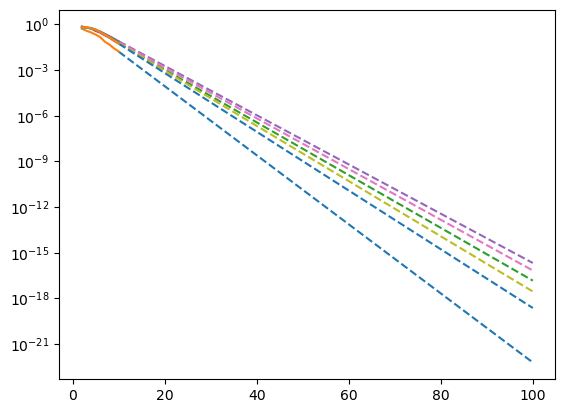

In [40]:
for i in range(kappa_conc_extrapolation.shape[0]):
    plt.plot(n_extrapolation, kappa_conc_extrapolation[i], linestyle='dashed')
    plt.plot(n_range, M_conc_kappa[i])
plt.yscale('log')
plt.show()

In [41]:
kappa_extrapolation = 1-kappa_conc_extrapolation

## N_spread

In [44]:
def N_spread(kappa, Delta_ensemble, V_p_n, n, P_spread=0.99, epsilon=1, gamma=1):
    N = (np.power(n*gamma*kappa,2)*V_p_n)/(np.power(epsilon*Delta_ensemble,2)*(1-P_spread))
    return(N)

In [45]:
i_n = 0
i_ZZ = 0

kappa = M_kappa[i_ZZ, i_n]
Delta = k_IQRS[i_ZZ, i_n]
V_p_n = V_medians_ZZ[i_ZZ,i_n]
V_p_n_noisy = V_medians_ZZ_noisy[i_ZZ,i_n]
n = n_values[i_n]
print(N_spread(kappa,Delta,V_p_n,n))
print(N_spread(kappa,Delta,V_p_n_noisy,n))

1067.7438515486913
6391.5093332055485


In [46]:
Ns_spread = np.empty((ZZ_values.shape[0], n_values.shape[0]))
Ns_spread_noisy = np.empty((ZZ_values.shape[0], n_values.shape[0]))

for ZZ_id, _ in enumerate(ZZ_values):
    for n_id, _ in enumerate(n_values):
        kappa = M_kappa[ZZ_id, n_id]
        Delta = k_IQRS[ZZ_id, n_id]
        V_p_n = V_medians_ZZ[ZZ_id,n_id]
        V_p_n_noisy = V_medians_ZZ_noisy[ZZ_id,n_id]
        n = n_values[n_id]
        Ns_spread[ZZ_id, n_id] = N_spread(kappa,Delta,V_p_n,n)        
        Ns_spread_noisy[ZZ_id, n_id] = N_spread(kappa,Delta,V_p_n_noisy,n)

## przerwa

In [47]:
Ns_spread_extrapolated = np.empty((ZZ_values.shape[0], n_extrapolation.shape[0]))
Ns_spread_extrapolated_noisy = np.empty((ZZ_values.shape[0], n_extrapolation.shape[0]))

for ZZ_id, _ in enumerate(ZZ_values):
    for n_id, _ in enumerate(n_extrapolation):
        n = n_extrapolation[n_id]
        kappa_ext = kappa_extrapolation[ZZ_id,n_id]
        Delta_ext = Delta_extrapolation[ZZ_id,n_id]
        V_p_n_exp = V_extrapolation[ZZ_id,n_id]
        V_p_n_exp_noisy = V_extrapolation_noisy[ZZ_id,n_id]
        Ns_spread_extrapolated[ZZ_id, n_id] = N_spread(kappa_ext,Delta_ext,V_p_n_exp,n) 
        Ns_spread_extrapolated_noisy[ZZ_id, n_id] = N_spread(kappa_ext,Delta_ext,V_p_n_exp_noisy,n) 

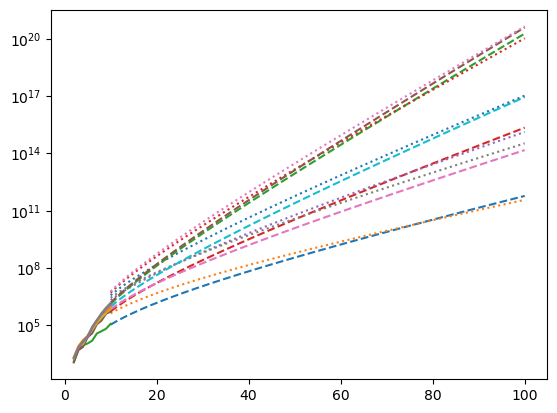

In [49]:
for i in range(Ns_spread_extrapolated.shape[0]):
    plt.plot(n_extrapolation, Ns_spread_extrapolated[i], linestyle='dashed')
    plt.plot(n_extrapolation, Ns_spread_extrapolated_noisy[i], linestyle='dotted')
    plt.plot(n_range, Ns_spread[i])
plt.yscale('log')
plt.show()

# Together

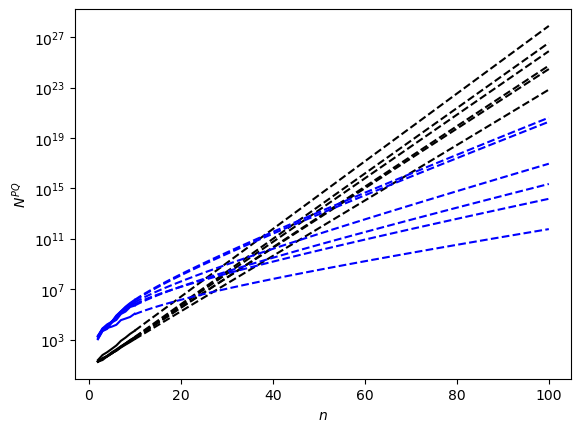

In [50]:
color = cm.rainbow(np.linspace(0, 1, NSRs_extrapolation.shape[0]))

for i in range(NSRs_extrapolation.shape[0]):
    plt.plot(n_extrapolation, NSRs_extrapolation[i], linestyle='dashed', c = 'black')
    plt.plot(n_range, NSRs_ZZ[i], c = 'black')
for i in range(Ns_spread_extrapolated.shape[0]):
    plt.plot(n_extrapolation, Ns_spread_extrapolated[i], linestyle='dashed', c = 'blue')
    plt.plot(n_range, Ns_spread[i], c = 'blue')
plt.yscale('log')
#plt.xlim((2,20))
#plt.ylim((0,1.e10))
plt.xlabel(r'$n$')
plt.ylabel(r'$N^{PQ}$')
plt.show()

In [43]:
step = 5

n_ext_plot = n_extrapolation[::step]
NSR_ext_plot = NSRs_extrapolation[:,::step]
Ns_spread_ext_plot = Ns_spread_extrapolated[:,::step]

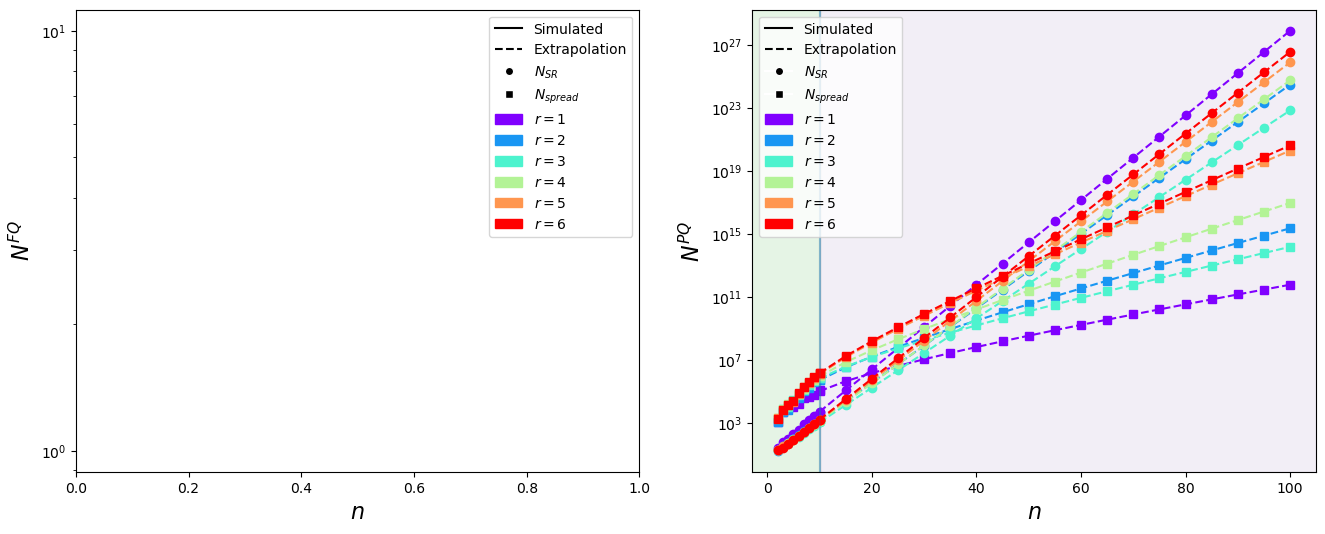

In [44]:
color = cm.rainbow(np.linspace(0, 1, NSRs_extrapolation.shape[0]))

bg_color = [plt.cm.Accent(i) for i in range(2)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

legend_entries = []

legend_entries.append(Line2D([], [], color='black', linestyle='-', label='Simulated'))
legend_entries.append(Line2D([], [], color='black', linestyle='--', label='Extrapolation'))
legend_entries.append( Line2D([], [], color="white", marker='o', markerfacecolor="black", label=r'$N_{SR}}$'))
legend_entries.append( Line2D([], [], color="white", marker='s', markerfacecolor="black", label=r'$N_{spread}}$'))

for i, c in enumerate(color):
    ax[1].plot(n_range,NSRs_ZZ[i], c=c, marker='o')
    ax[1].plot(n_ext_plot, NSR_ext_plot[i], c=c, marker='o', linestyle = '--')
    ax[1].plot(n_range,Ns_spread[i], c=c, marker='s')
    ax[1].plot(n_ext_plot, Ns_spread_ext_plot[i], c=c, marker='s', linestyle = '--')

    ax[1].axvline(n_range[-1], alpha=0.1)

    legend_entries.append( mpatches.Patch(color=color[i], label=r'$r =$'+str(i+1)) )

left,right = ax[1].get_xlim()

ax[1].axvspan(-10, n_range[-1], alpha=0.2, color=bg_color[0])
ax[1].axvspan(n_range[-1], n_extrapolation[-1]+10, alpha=0.2, color=bg_color[1])

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[1].set_xlim((left,right))
#ax[1].set_ylim((1,1.e15))

ax[0].set_xlabel(r'$n$', fontsize=16)
ax[1].set_xlabel(r'$n$', fontsize=16)
#ax[0].set_xticks([int(i) for i in x_full if i%2==0])
#ax[1].set_xticks([int(i) for i in x_full if i%2==0])
ax[0].set_ylabel(r'$N^{FQ}$', fontsize=16)
ax[1].set_ylabel(r'$N^{PQ}$', fontsize=16)


ax[0].legend(handles=legend_entries)
ax[1].legend(handles=legend_entries)

plt.show()

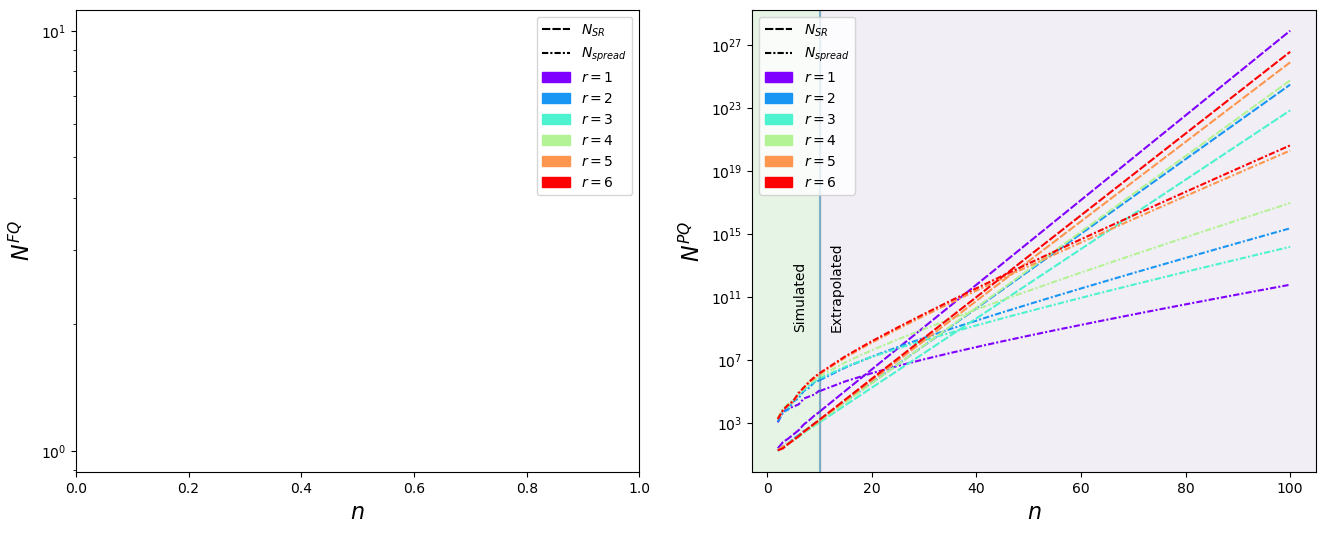

In [45]:
color = cm.rainbow(np.linspace(0, 1, NSRs_extrapolation.shape[0]))

bg_color = [plt.cm.Accent(i) for i in range(2)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

legend_entries = []

legend_entries.append(Line2D([], [], color='black', linestyle=(0, (4, 1)), label=r'$N_{SR}}$'))
legend_entries.append(Line2D([], [], color='black', linestyle=(0, (3, 1, 1, 1)), label=r'$N_{spread}}$'))
#legend_entries.append( Line2D([], [], color="white", marker='o', markerfacecolor="black", label=r'$N_{SR}}$'))
#legend_entries.append( Line2D([], [], color="white", marker='s', markerfacecolor="black", label=r'$N_{spread}}$'))

for i, c in enumerate(color):
    ax[1].plot(n_range,NSRs_ZZ[i], c=c, linestyle = (0, (4, 1)))
    ax[1].plot(n_ext_plot, NSR_ext_plot[i], c=c, linestyle = (0, (4, 1)))
    ax[1].plot(n_range,Ns_spread[i], c=c, linestyle = (0, (3, 1, 1, 1)))
    ax[1].plot(n_ext_plot, Ns_spread_ext_plot[i], c=c, linestyle = (0, (3, 1, 1, 1)))

    ax[1].axvline(n_range[-1], alpha=0.1)

    legend_entries.append( mpatches.Patch(color=color[i], label=r'$r =$'+str(i+1)) )

left,right = ax[1].get_xlim()

ax[1].axvspan(-10, n_range[-1], alpha=0.2, color=bg_color[0])
ax[1].axvspan(n_range[-1], n_extrapolation[-1]+10, alpha=0.2, color=bg_color[1])

ax[1].text(n_range[-1]-5,1.e9,'Simulated', rotation='vertical')
ax[1].text(n_range[-1]+2,1.e9,'Extrapolated', rotation='vertical')

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[1].set_xlim((left,right))
#ax[1].set_ylim((1,1.e15))

ax[0].set_xlabel(r'$n$', fontsize=16)
ax[1].set_xlabel(r'$n$', fontsize=16)
#ax[0].set_xticks([int(i) for i in x_full if i%2==0])
#ax[1].set_xticks([int(i) for i in x_full if i%2==0])
ax[0].set_ylabel(r'$N^{FQ}$', fontsize=16)
ax[1].set_ylabel(r'$N^{PQ}$', fontsize=16)


ax[0].legend(handles=legend_entries)
ax[1].legend(handles=legend_entries, loc='upper left')

plt.show()

### Success rate export

In [46]:
N_data = np.array([n_range, NSRs_ZZ[0],NSRs_ZZ[1],NSRs_ZZ[2],NSRs_ZZ[3],NSRs_ZZ[4],NSRs_ZZ[5]]).T
N_data_ext = np.array([n_extrapolation, NSRs_extrapolation[0],NSRs_extrapolation[1],NSRs_extrapolation[2],NSRs_extrapolation[3],NSRs_extrapolation[4],NSRs_extrapolation[5]]).T
df = pd.DataFrame(N_data, columns=['n', 'ZZ1', 'ZZ2', 'ZZ3', 'ZZ4', 'ZZ5', 'ZZ6'])
df_ext = pd.DataFrame(N_data_ext, columns=['n', 'ZZ1', 'ZZ2', 'ZZ3', 'ZZ4', 'ZZ5', 'ZZ6'])
df_ext

,n,ZZ1,ZZ2,ZZ3,ZZ4,ZZ5,ZZ6
0,10.0,5.120587e+03,1.493745e+03,1.084478e+03,1.292543e+03,1.487542e+03,1.602552e+03
1,11.0,9.504857e+03,2.575359e+03,1.799569e+03,2.247630e+03,2.659435e+03,2.911934e+03
2,12.0,1.764296e+04,4.440162e+03,2.986182e+03,3.908449e+03,4.754550e+03,5.291161e+03
3,13.0,3.274894e+04,7.655260e+03,4.955231e+03,6.796482e+03,8.500205e+03,9.614360e+03
4,14.0,6.078874e+04,1.319839e+04,8.222645e+03,1.181854e+04,1.519670e+04,1.746988e+04
...,...,...,...,...,...,...,...
86,96.0,6.473554e+26,3.300144e+23,8.927268e+21,5.963476e+23,7.447164e+24,3.240271e+25
87,97.0,1.201624e+27,5.689760e+23,1.481379e+22,1.037001e+24,1.331407e+25,5.887769e+25
88,98.0,2.230460e+27,9.809685e+23,2.458181e+22,1.803262e+24,2.380296e+25,1.069843e+26
89,99.0,4.140191e+27,1.691283e+24,4.079073e+22,3.135730e+24,4.255504e+25,1.943970e+26


In [47]:
df.to_csv('results/N_estimates/SR_PQ', index=False)
df_ext.to_csv('results/N_estimates/SR_PQ_ext', index=False)

### Spread export

In [48]:
N_data = np.array([n_range, Ns_spread[0],Ns_spread[1],Ns_spread[2],Ns_spread[3],Ns_spread[4],Ns_spread[5]]).T
N_data_ext = np.array([n_extrapolation, Ns_spread_extrapolated[0],Ns_spread_extrapolated[1],Ns_spread_extrapolated[2],Ns_spread_extrapolated[3],Ns_spread_extrapolated[4],Ns_spread_extrapolated[5]]).T
df = pd.DataFrame(N_data, columns=['n', 'ZZ1', 'ZZ2', 'ZZ3', 'ZZ4', 'ZZ5', 'ZZ6'])
df_ext = pd.DataFrame(N_data_ext, columns=['n', 'ZZ1', 'ZZ2', 'ZZ3', 'ZZ4', 'ZZ5', 'ZZ6'])
df_ext

,n,ZZ1,ZZ2,ZZ3,ZZ4,ZZ5,ZZ6
0,10.0,1.029561e+05,5.072525e+05,6.530073e+05,9.005203e+05,1.243998e+06,1.427195e+06
1,11.0,1.425064e+05,7.753297e+05,9.765728e+05,1.433012e+06,2.141020e+06,2.469419e+06
2,12.0,1.929557e+05,1.150044e+06,1.412762e+06,2.209452e+06,3.571052e+06,4.140432e+06
3,13.0,2.568298e+05,1.667575e+06,1.993360e+06,3.326338e+06,5.818495e+06,6.782903e+06
4,14.0,3.371806e+05,2.375719e+06,2.758822e+06,4.916157e+06,9.311384e+06,1.091670e+07
...,...,...,...,...,...,...,...
86,96.0,3.314108e+11,9.419313e+14,7.173701e+13,3.318020e+16,5.080472e+19,1.051953e+20
87,97.0,3.819727e+11,1.167776e+15,8.601875e+13,4.257957e+16,7.074930e+19,1.475188e+20
88,98.0,4.401549e+11,1.447464e+15,1.031218e+14,5.463001e+16,9.850267e+19,2.068265e+20
89,99.0,5.070939e+11,1.793764e+15,1.235998e+14,7.007624e+16,1.371145e+20,2.899176e+20


In [49]:
df.to_csv('results/N_estimates/Spread_PQ', index=False)
df_ext.to_csv('results/N_estimates/Spread_PQ_ext', index=False)